In [3]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import imutils

ModuleNotFoundError: No module named 'imutils'

In [5]:
import imutils

In [70]:
def contour_plot(image,plot=False):
    grayscale = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    grayscale = cv2.GaussianBlur(grayscale,(5,5),0)
    threshold_image = cv2.threshold(grayscale,45,255,cv2.THRESH_BINARY)[1]
    threshold_image = cv2.erode(threshold_image,None,iterations=5)
    threshold_image = cv2.dilate(threshold_image,None,iterations=5)
    
    contour = cv2.findContours(threshold_image.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contour = imutils.grab_contours(contour)
    c = max(contour,key=cv2.contourArea)
    
    extreme_left_pnts = tuple(c[c[:,:,0].argmin()][0])
    extreme_right_pnts = tuple(c[c[:,:,0].argmax()][0])
    extreme_top_pnts = tuple(c[c[:,:,1].argmin()][0])
    extreme_bottom_pnts = tuple(c[c[:,:,1].argmax()][0])
    
    new_image = image[extreme_top_pnts[1]:extreme_bottom_pnts[1],extreme_left_pnts[0]:extreme_right_pnts[0]]
    
    if plot:
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.title("Original Image")
        
        
        plt.subplot(1,2,2)
        plt.imshow(new_image)
        plt.title("Cropped Image")
        
        plt.show()
    
    return new_image

imgdf000002FF.jpg


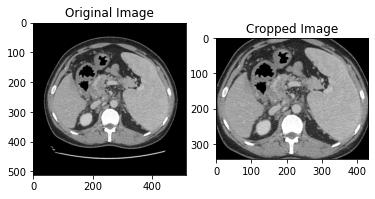

In [127]:
import os
count = 0
for item in os.listdir('Study_84525'):
    
    print(item)
    example_image = cv2.imread('Study_84525'+'/'+item)
    contour_plot(example_image,plot=True)
    count += 1
    if count==1:
        break

# VNet Arch

In [132]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Conv2DTranspose

In [166]:
#Building V-Net Model
x = 'd12'
inputs = tf.keras.layers.Input([128,128,3])

#Contraction Path
c1 = tf.keras.layers.Conv2D(16,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c4)
c5 = tf.keras.layers.Conv2D(256,(3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

#Expansion Path
u1 = tf.keras.layers.Conv2DTranspose(128,(2,2), strides=(2,2), padding='same')(c5)
u1 = tf.keras.layers.concatenate([u1,c4])
c6 = tf.keras.layers.Conv2D(128,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(u1)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u2 = tf.keras.layers.Conv2DTranspose(64,(2,2), strides=(2,2), padding='same')(c6)
u2 = tf.keras.layers.concatenate([u2,c3])
c7 = tf.keras.layers.Conv2D(64,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(u2)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u3 = tf.keras.layers.Conv2DTranspose(32,(2,2), strides=(1,1), padding='same')(c7)
u3 = tf.keras.layers.concatenate([u3,c2])
c8 = tf.keras.layers.Conv2D(32,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(u3)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(32,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u4 = tf.keras.layers.Conv2DTranspose(16,(2,2), strides=(1,1), padding='same')(c8)
u4 = tf.keras.layers.concatenate([u4,c1],axis=3)
c9 = tf.keras.layers.Conv2D(16,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(u4)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(16,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid')(c9)

model = tf.keras.Model(input=[inputs], output = [outputs])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 32, 32, 128), (None, 16, 16, 128)]

# SKlearn contour

In [130]:
from skimage.measure import find_contours

p = find_contours(x, level= 0.8,fully_connected='low', positive_orientation='low')

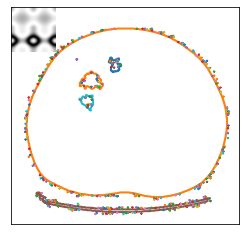

In [131]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure


# Construct some test data
x, y = np.ogrid[-np.pi:np.pi:100j, -np.pi:np.pi:100j]
r = np.sin(np.exp((np.sin(x)**3 + np.cos(y)**2)))

# Find contours at a constant value of 0.8
#contours = measure.find_contours(x, 0.8)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(r, cmap=plt.cm.gray)

for contour in p:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [84]:
512*512*3

786432

In [120]:
x = np.array([q])

In [129]:
x.shape

(512, 512)

array(None, dtype=object)

In [128]:
x = example_image[:,:,0]